In [1]:
import numpy as np

from utils.loadData import loadDataWithNews
from lstm.preprocessing import dataToTimeSeriesMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional
from lstm.callbacks import es_callback, modelckpt_callback
from keras.utils.vis_utils import plot_model

In [2]:
df = loadDataWithNews()

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
features.head()

,Open,High,Low,Close,Volume,positive,neutral,negative
0,21308.351563,23642.660156,21234.675781,22805.162109,71378606374,2,3,0
1,22806.796875,23238.601563,22399.812500,23137.960938,40387896275,3,2,0
2,23132.865234,24085.855469,22826.472656,23869.832031,38487546580,0,1,0
3,23861.765625,24209.660156,23147.710938,23477.294922,37844228422,1,2,0
4,23474.455078,24059.982422,22159.367188,22803.082031,45852713981,3,3,0


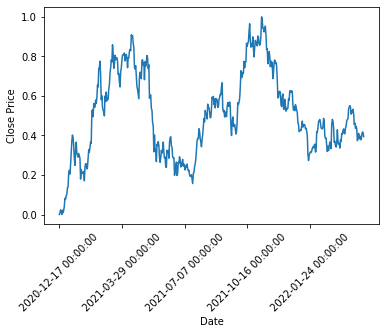

In [4]:
normalized_data, scaler = normalizeAtOnce(features)
# normalized_data = np.concatenate([normalized_data, features.iloc[:,-3:]], axis=1)
show_data_simple(normalized_data[:,3], df["Date"], ticks=100)

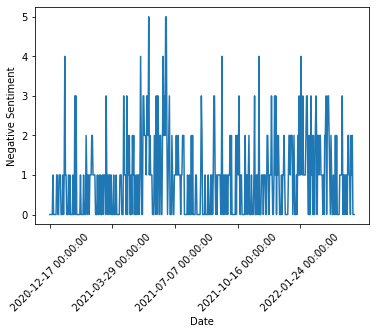

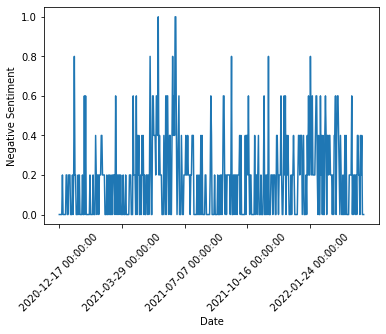

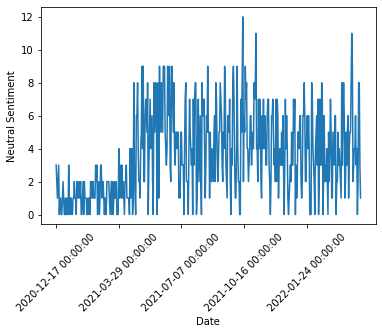

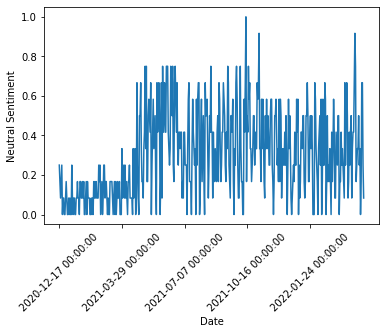

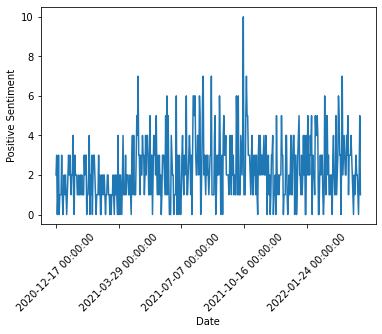

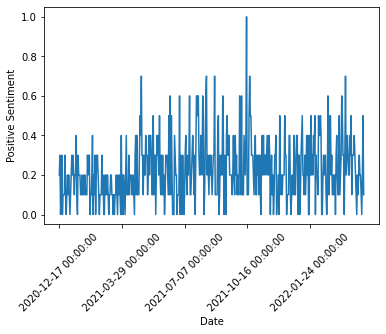

In [6]:
show_data_simple(features["negative"], df["Date"], name="Negative Sentiment", ticks=100)
show_data_simple(normalized_data[:,-1], df["Date"], name="Negative Sentiment", ticks=100)
show_data_simple(features["neutral"], df["Date"], name="Neutral Sentiment", ticks=100)
show_data_simple(normalized_data[:,-2], df["Date"], name="Neutral Sentiment", ticks=100)
show_data_simple(features["positive"], df["Date"], name="Positive Sentiment", ticks=100)
show_data_simple(normalized_data[:,-3], df["Date"], name="Positive Sentiment", ticks=100)

In [ ]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 64,
    "epochs": 20,
    "features": normalized_data.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 3], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [ ]:
model = getModel(config)
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [ ]:
x, y = dataToTimeSeriesMultiDimensional(x_test, y_test[:,3], config["past"], config["future"])

In [ ]:
evaluateModelQuick(model, x, y)

In [ ]:
showRegressionExampleMultiDimensional(x[0], y[0], model, scaler, withNews=True)

In [ ]:
evaluateFinal(getModel, dataset_train, dataset_val, x, y, config, "regression_with_news_new")